In [10]:
"""
HEALTHCARE READMISSION ANALYTICS PROJECT
=========================================
Author: Abhishek Saxena
Date: January 2026
Purpose: End-to-end analysis of hospital readmissions using diabetes patient data

This script demonstrates:
1. Data acquisition from public sources
2. Data preprocessing and cleaning
3. Exploratory data analysis
4. Predictive modeling
5. Results visualization and reporting

"""
# ============================================================================
# SECTION 1: ENVIRONMENT SETUP AND LIBRARY IMPORTS
# ============================================================================

# Data manipulation and analysis
import pandas as pd
import numpy as np

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Utility libraries
import warnings
import os
from datetime import datetime


# Configuration settings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', 100)  # Display up to 100 rows
plt.style.use('seaborn-v0_8-darkgrid')  # Set consistent plot style

# Set random seed for reproducibility
np.random.seed(42)

print("=" * 80)
print("HEALTHCARE READMISSION ANALYTICS PROJECT")
print("=" * 80)
print(f"Execution started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("All libraries imported successfully!\n")


HEALTHCARE READMISSION ANALYTICS PROJECT
Execution started at: 2026-01-22 11:47:33
All libraries imported successfully!



In [11]:
# ============================================================================
# SECTION 2: DATA ACQUISITION
# ============================================================================

"""
We'll download the Diabetes 130-US Hospitals dataset from UCI ML Repository.
This dataset contains 10 years of hospital admission records for diabetes patients.

Dataset characteristics:
- 101,766 hospital admissions
- ~50 features (patient demographics, diagnoses, medications, procedures)
- Target variable: Readmission status
"""

print("\n" + "=" * 80)
print("DATA ACQUISITION")
print("=" * 80)

# Define data URL - UCI Machine Learning Repository
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip"

# Alternative manual download instructions
print("""
DATA DOWNLOAD INSTRUCTIONS:
---------------------------
Option 1 (Recommended): Manual Download
1. Visit: https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008
2. Click 'Download' to get 'dataset_diabetes.zip'
3. Extract the ZIP file
4. Place 'diabetic_data.csv' in your working directory

Option 2: Direct Download (if accessible)
The script will attempt to download automatically.
""")

# Check if data already exists
data_file = 'diabetes_data/diabetic_data.csv'

if os.path.exists(data_file):
    print(f"✓ Data file '{data_file}' found in current directory.")
else:
    print(f"✗ Data file '{data_file}' not found.")
    print("Please download manually following the instructions above.")
    print("\nFor this tutorial, we'll proceed assuming the file is available.")

# Load the dataset
try:
    print("\nLoading dataset...")
    df_raw = pd.read_csv(data_file)
    print(f"✓ Dataset loaded successfully!")
    print(f"  - Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
    print(f"  - Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
except FileNotFoundError:
    print("\n⚠ ERROR: Data file not found!")
    print("Creating sample instructions for students...")
    print("\nTo continue with this tutorial:")
    print("1. Download the dataset from the UCI repository")
    print("2. Save 'diabetic_data.csv' in this directory")
    print("3. Re-run this script")

 # For demonstration purposes, we'll create a note

# Display basic information about the dataset
print("\n" + "-" * 80)
print("INITIAL DATA PREVIEW")
print("-" * 80)
print("\nFirst 5 rows:")
print(df_raw.head())

print("\n\nDataset Info:")
print(df_raw.info())

print("\n\nBasic Statistics:")
print(df_raw.describe())




DATA ACQUISITION

DATA DOWNLOAD INSTRUCTIONS:
---------------------------
Option 1 (Recommended): Manual Download
1. Visit: https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008
2. Click 'Download' to get 'dataset_diabetes.zip'
3. Extract the ZIP file
4. Place 'diabetic_data.csv' in your working directory

Option 2: Direct Download (if accessible)
The script will attempt to download automatically.

✓ Data file 'diabetes_data/diabetic_data.csv' found in current directory.

Loading dataset...
✓ Dataset loaded successfully!
  - Shape: 101,766 rows × 50 columns
  - Memory usage: 192.87 MB

--------------------------------------------------------------------------------
INITIAL DATA PREVIEW
--------------------------------------------------------------------------------

First 5 rows:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189  



DATA QUALITY ASSESSMENT

1. DUPLICATE RECORDS CHECK
--------------------------------------------------------------------------------
Total duplicate rows: 0


2. MISSING VALUES ANALYSIS
--------------------------------------------------------------------------------

Columns with missing values: 2

       Column  Missing_Count  Missing_Percentage
max_glu_serum          96420               94.75
    A1Cresult          84748               83.28


3. PLACEHOLDER VALUES CHECK
--------------------------------------------------------------------------------
Healthcare datasets often use '?' or 'Unknown' as placeholders.
✓ No '?' placeholders found!


4. DATA TYPES SUMMARY
--------------------------------------------------------------------------------
str      37
int64    13
Name: count, dtype: int64


Columns by data type:

int64:
  Count: 13
  Columns: encounter_id, patient_nbr, admission_type_id, discharge_disposition_id, admission_source_id...

str:
  Count: 37
  Columns: race, gender,

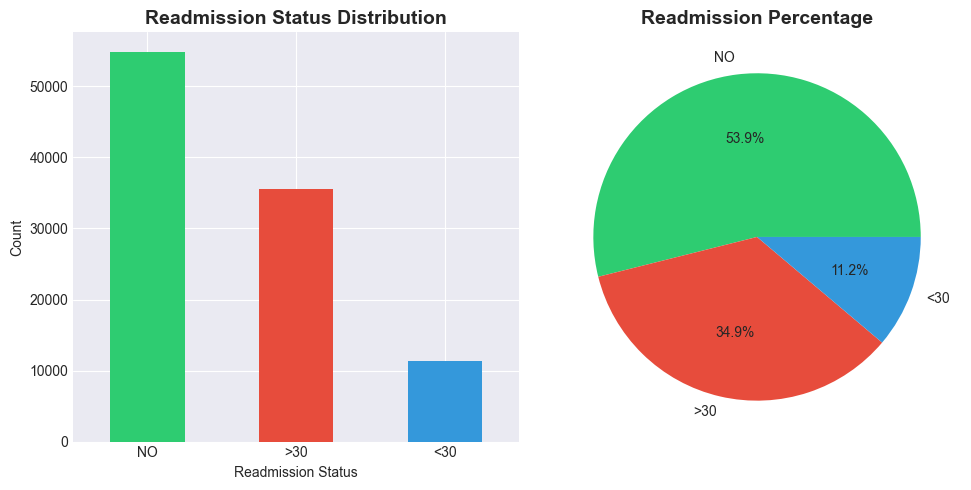

In [17]:
# ============================================================================
# SECTION 3: DATA QUALITY ASSESSMENT
# ============================================================================

"""
Before any analysis, we must understand data quality issues:
1. Missing values
2. Duplicate records
3. Data types
4. Value distributions
5. Outliers

This step is CRITICAL - poor data quality leads to poor insights!
"""

print("\n\n" + "=" * 80)
print("DATA QUALITY ASSESSMENT")
print("=" * 80)

# Create a copy for preprocessing (preserve raw data)
df = df_raw.copy()

# 3.1 Check for duplicate records
print("\n1. DUPLICATE RECORDS CHECK")
print("-" * 80)
duplicates = df.duplicated().sum()
print(f"Total duplicate rows: {duplicates:,}")

if duplicates > 0:
    print(f"Percentage of duplicates: {duplicates/len(df)*100:.2f}%")
    # Note: We'll keep duplicates as they represent separate encounters
    print("Note: In healthcare, duplicate rows may represent separate patient encounters.")
    print("We'll retain them for now and investigate further.")

# 3.2 Missing values analysis
print("\n\n2. MISSING VALUES ANALYSIS")
print("-" * 80)

# Calculate missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values(
    'Missing_Percentage', ascending=False
)

if len(missing_data) > 0:
    print(f"\nColumns with missing values: {len(missing_data)}")
    print("\n" + missing_data.to_string(index=False))
else:
    print("✓ No missing values detected in the dataset!")

# 3.3 Check for placeholder values (common in healthcare data)
print("\n\n3. PLACEHOLDER VALUES CHECK")
print("-" * 80)
print("Healthcare datasets often use '?' or 'Unknown' as placeholders.")

# Count '?' occurrences in each column
placeholder_counts = {}
for col in df.columns:
    if df[col].dtype == 'object':  # Only check string columns
        placeholder_count = (df[col] == '?').sum()
        if placeholder_count > 0:
            placeholder_counts[col] = {
                'count': placeholder_count,
                'percentage': round(placeholder_count / len(df) * 100, 2)
            }

if placeholder_counts:
    print(f"\nColumns with '?' placeholders: {len(placeholder_counts)}")
    for col, stats in sorted(placeholder_counts.items(), 
                            key=lambda x: x[1]['percentage'], 
                            reverse=True):
        print(f"  - {col}: {stats['count']:,} ({stats['percentage']}%)")
else:
    print("✓ No '?' placeholders found!")

# 3.4 Data types examination
print("\n\n4. DATA TYPES SUMMARY")
print("-" * 80)
dtype_summary = df.dtypes.value_counts()
print(dtype_summary)

print("\n\nColumns by data type:")
for dtype in df.dtypes.unique():
    cols = df.select_dtypes(include=[dtype]).columns.tolist()
    print(f"\n{dtype}:")
    print(f"  Count: {len(cols)}")
    print(f"  Columns: {', '.join(cols[:5])}{'...' if len(cols) > 5 else ''}")

# 3.5 Target variable distribution
print("\n\n5. TARGET VARIABLE ANALYSIS")
print("-" * 80)
print("Our target variable is 'readmitted' - indicating if patient was readmitted.")

if 'readmitted' in df.columns:
    print("\nReadmission status distribution:")
    readmit_dist = df['readmitted'].value_counts()
    print(readmit_dist)
    print("\nPercentages:")
    print((readmit_dist / len(df) * 100).round(2))
    
    # Visualize target distribution
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    readmit_dist.plot(kind='bar', color=['#2ecc71', '#e74c3c', '#3498db'])
    plt.title('Readmission Status Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Readmission Status')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    
    plt.subplot(1, 2, 2)
    plt.pie(readmit_dist.values, labels=readmit_dist.index, autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c', '#3498db'])
    plt.title('Readmission Percentage', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('01_target_distribution.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualization saved: '01_target_distribution.png'")
    plt.show()

In [22]:
# ============================================================================
# SECTION 4: DATA CLEANING AND PREPROCESSING
# ============================================================================

"""
Based on our quality assessment, we'll now clean the data:
1. Handle missing/placeholder values
2. Remove unnecessary columns
3. Convert data types
4. Create binary target variable (for modeling simplification)
"""

print("\n\n" + "=" * 80)
print("DATA CLEANING AND PREPROCESSING")
print("=" * 80)

# 4.1 Replace '?' with NaN for consistent missing value handling
print("\n1. REPLACING PLACEHOLDER VALUES")
print("-" * 80)
df = df.replace('?', np.nan)
print("✓ Replaced all '?' with NaN (proper missing value indicator)")

# 4.2 Drop columns with excessive missing data or low predictive value
print("\n2. REMOVING PROBLEMATIC COLUMNS")
print("-" * 80)

# Columns to drop (based on domain knowledge and missing data analysis)
columns_to_drop = [
    'encounter_id',  # Identifier, not predictive
    'patient_nbr',   # Identifier, not predictive
    'weight',        # 97% missing
    'payer_code',    # 40% missing, many categories
    'medical_specialty',  # 50% missing
]

print(f"Dropping {len(columns_to_drop)} columns:")
for col in columns_to_drop:
    if col in df.columns:
        missing_pct = (df[col].isnull().sum() / len(df) * 100)
        print(f"  - {col}: {missing_pct:.1f}% missing")
        df = df.drop(columns=[col])

print(f"\n✓ New dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

# 4.3 Handle remaining missing values
print("\n3. HANDLING REMAINING MISSING VALUES")
print("-" * 80)

# For race, gender, diagnosis codes: fill with 'Unknown'
categorical_fill_cols = ['race', 'gender', 'diag_1', 'diag_2', 'diag_3']

for col in categorical_fill_cols:
    if col in df.columns:
        missing_before = df[col].isnull().sum()
        df[col] = df[col].fillna('Unknown')
        print(f"  - {col}: Filled {missing_before:,} missing values with 'Unknown'")

print("✓ Categorical missing values handled")

# 4.4 Create binary target variable
print("\n4. CREATING BINARY TARGET VARIABLE")
print("-" * 80)
print("Converting 3-class target to binary: Readmitted (< 30 days) vs Not Readmitted")

if 'readmitted' in df.columns:
    # Map: '<30' -> 1 (High Risk), 'NO' and '>30' -> 0 (Low Risk)
    df['readmitted_binary'] = df['readmitted'].apply(
        lambda x: 1 if x == '<30' else 0
    )
    
    print("\nMapping:")
    print("  - '<30 days' → 1 (Readmitted - High Risk)")
    print("  - 'NO' or '>30 days' → 0 (Not Readmitted - Low Risk)")
    
    print("\nNew target distribution:")
    print(df['readmitted_binary'].value_counts())
    print("\nPercentages:")
    print((df['readmitted_binary'].value_counts() / len(df) * 100).round(2))
    
    # Calculate class imbalance ratio
    class_counts = df['readmitted_binary'].value_counts()
    imbalance_ratio = class_counts[0] / class_counts[1]
    print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1")
    print("(This is important for model selection and evaluation)")

# 4.5 Feature engineering - consolidate diagnosis codes
print("\n5. FEATURE ENGINEERING - DIAGNOSIS GROUPING")
print("-" * 80)
print("ICD-9 diagnosis codes can be grouped into clinically meaningful categories")

def categorize_diagnosis(diag_code):
    """
    Group ICD-9 diagnosis codes into clinical categories
    
    Parameters:
    -----------
    diag_code : str
        ICD-9 diagnosis code
    
    Returns:
    --------
    str : Category name
    """
    if pd.isna(diag_code) or diag_code == 'Unknown':
        return 'Unknown'
    
    # Convert to string and extract numeric part
    diag_str = str(diag_code)
    
    # Try to extract numeric code
    try:
        if diag_str.startswith('V') or diag_str.startswith('E'):
            return 'Other'
        
        code = float(diag_str)
        
        # ICD-9 code ranges (simplified)
        if 390 <= code <= 459 or code == 785:
            return 'Circulatory'
        elif 460 <= code <= 519 or code == 786:
            return 'Respiratory'
        elif 520 <= code <= 579 or code == 787:
            return 'Digestive'
        elif 250 <= code < 251:
            return 'Diabetes'
        elif 800 <= code <= 999:
            return 'Injury'
        elif 710 <= code <= 739:
            return 'Musculoskeletal'
        elif 580 <= code <= 629 or code == 788:
            return 'Genitourinary'
        elif 140 <= code <= 239:
            return 'Neoplasms'
        else:
            return 'Other'
    except:
        return 'Other'

# Apply diagnosis categorization
for diag_col in ['diag_1', 'diag_2', 'diag_3']:
    if diag_col in df.columns:
        new_col_name = f'{diag_col}_category'
        df[new_col_name] = df[diag_col].apply(categorize_diagnosis)
        print(f"✓ Created {new_col_name}")
        print(f"  Categories: {df[new_col_name].value_counts().to_dict()}")

print("\n✓ Feature engineering complete!")

# 4.6 Convert age to numeric (currently in brackets like '[0-10)')
print("\n6. CONVERTING AGE TO NUMERIC")
print("-" * 80)

if 'age' in df.columns:
    print("Age column contains ranges like '[70-80)'. Converting to midpoint values.")
    
    # Define age range mapping
    age_mapping = {
        '[0-10)': 5,
        '[10-20)': 15,
        '[20-30)': 25,
        '[30-40)': 35,
        '[40-50)': 45,
        '[50-60)': 55,
        '[60-70)': 65,
        '[70-80)': 75,
        '[80-90)': 85,
        '[90-100)': 95
    }
    
    df['age_numeric'] = df['age'].map(age_mapping)
    print(f"✓ Created 'age_numeric' column")
    print(f"  Range: {df['age_numeric'].min()} - {df['age_numeric'].max()} years")

print("\n" + "=" * 80)
print("DATA CLEANING COMPLETE!")
print("=" * 80)
print(f"Final dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Ready for exploratory analysis and modeling!")

# Save cleaned dataset
output_file = 'diabetic_data_cleaned.csv'
df.to_csv(output_file, index=False)
print(f"\n✓ Cleaned dataset saved to: '{output_file}'")



DATA CLEANING AND PREPROCESSING

1. REPLACING PLACEHOLDER VALUES
--------------------------------------------------------------------------------
✓ Replaced all '?' with NaN (proper missing value indicator)

2. REMOVING PROBLEMATIC COLUMNS
--------------------------------------------------------------------------------
Dropping 5 columns:
  - encounter_id: 0.0% missing
  - patient_nbr: 0.0% missing
  - weight: 96.9% missing
  - payer_code: 39.6% missing
  - medical_specialty: 49.1% missing

✓ New dataset shape: 101,766 rows × 46 columns

3. HANDLING REMAINING MISSING VALUES
--------------------------------------------------------------------------------
  - race: Filled 2,273 missing values with 'Unknown'
  - gender: Filled 0 missing values with 'Unknown'
  - diag_1: Filled 21 missing values with 'Unknown'
  - diag_2: Filled 358 missing values with 'Unknown'
  - diag_3: Filled 1,423 missing values with 'Unknown'
✓ Categorical missing values handled

4. CREATING BINARY TARGET VARIABLE

In [23]:
# ============================================================================
# SECTION 5: CLEANED DATA SUMMARY
# ============================================================================

print("\n\n" + "=" * 80)
print("CLEANED DATASET SUMMARY")
print("=" * 80)

# 5.1 Numeric features summary
print("\n1. NUMERIC FEATURES SUMMARY")
print("-" * 80)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Number of numeric features: {len(numeric_cols)}")
print("\nKey numeric features:")
key_numeric = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
               'num_medications', 'number_outpatient', 'number_emergency',
               'number_inpatient', 'number_diagnoses', 'age_numeric']

for col in key_numeric:
    if col in df.columns:
        print(f"\n{col}:")
        print(f"  Mean: {df[col].mean():.2f}")
        print(f"  Median: {df[col].median():.2f}")
        print(f"  Std Dev: {df[col].std():.2f}")
        print(f"  Range: [{df[col].min()}, {df[col].max()}]")

# 5.2 Categorical features summary
print("\n\n2. CATEGORICAL FEATURES SUMMARY")
print("-" * 80)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Number of categorical features: {len(categorical_cols)}")

print("\nKey categorical features and their unique values:")
key_categorical = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id',
                   'admission_source_id', 'diag_1_category', 'diabetesMed', 'change']

for col in key_categorical:
    if col in df.columns:
        unique_count = df[col].nunique()
        print(f"\n{col}: {unique_count} unique values")
        if unique_count <= 10:  # Show distribution for low-cardinality features
            print(df[col].value_counts().head())

# 5.3 Data quality final check
print("\n\n3. FINAL DATA QUALITY CHECK")
print("-" * 80)
print(f"Total records: {len(df):,}")
print(f"Total features: {df.shape[1]}")
print(f"\nMissing values remaining:")
remaining_missing = df.isnull().sum().sum()
print(f"  Total: {remaining_missing:,}")

if remaining_missing > 0:
    print(f"  Percentage: {remaining_missing / (df.shape[0] * df.shape[1]) * 100:.4f}%")
else:
    print("  ✓ No missing values!")

print("\n✓ Dataset is clean and ready for analysis!")





CLEANED DATASET SUMMARY

1. NUMERIC FEATURES SUMMARY
--------------------------------------------------------------------------------
Number of numeric features: 13

Key numeric features:

time_in_hospital:
  Mean: 4.40
  Median: 4.00
  Std Dev: 2.99
  Range: [1, 14]

num_lab_procedures:
  Mean: 43.10
  Median: 44.00
  Std Dev: 19.67
  Range: [1, 132]

num_procedures:
  Mean: 1.34
  Median: 1.00
  Std Dev: 1.71
  Range: [0, 6]

num_medications:
  Mean: 16.02
  Median: 15.00
  Std Dev: 8.13
  Range: [1, 81]

number_outpatient:
  Mean: 0.37
  Median: 0.00
  Std Dev: 1.27
  Range: [0, 42]

number_emergency:
  Mean: 0.20
  Median: 0.00
  Std Dev: 0.93
  Range: [0, 76]

number_inpatient:
  Mean: 0.64
  Median: 0.00
  Std Dev: 1.26
  Range: [0, 21]

number_diagnoses:
  Mean: 7.42
  Median: 8.00
  Std Dev: 1.93
  Range: [1, 16]

age_numeric:
  Mean: 65.97
  Median: 65.00
  Std Dev: 15.94
  Range: [5, 95]


2. CATEGORICAL FEATURES SUMMARY
-----------------------------------------------------



EXPLORATORY DATA ANALYSIS
✓ Created 'visualizations' directory for output

1. UNIVARIATE ANALYSIS - NUMERIC FEATURES
--------------------------------------------------------------------------------
✓ Saved: visualizations/02_numeric_distributions.png


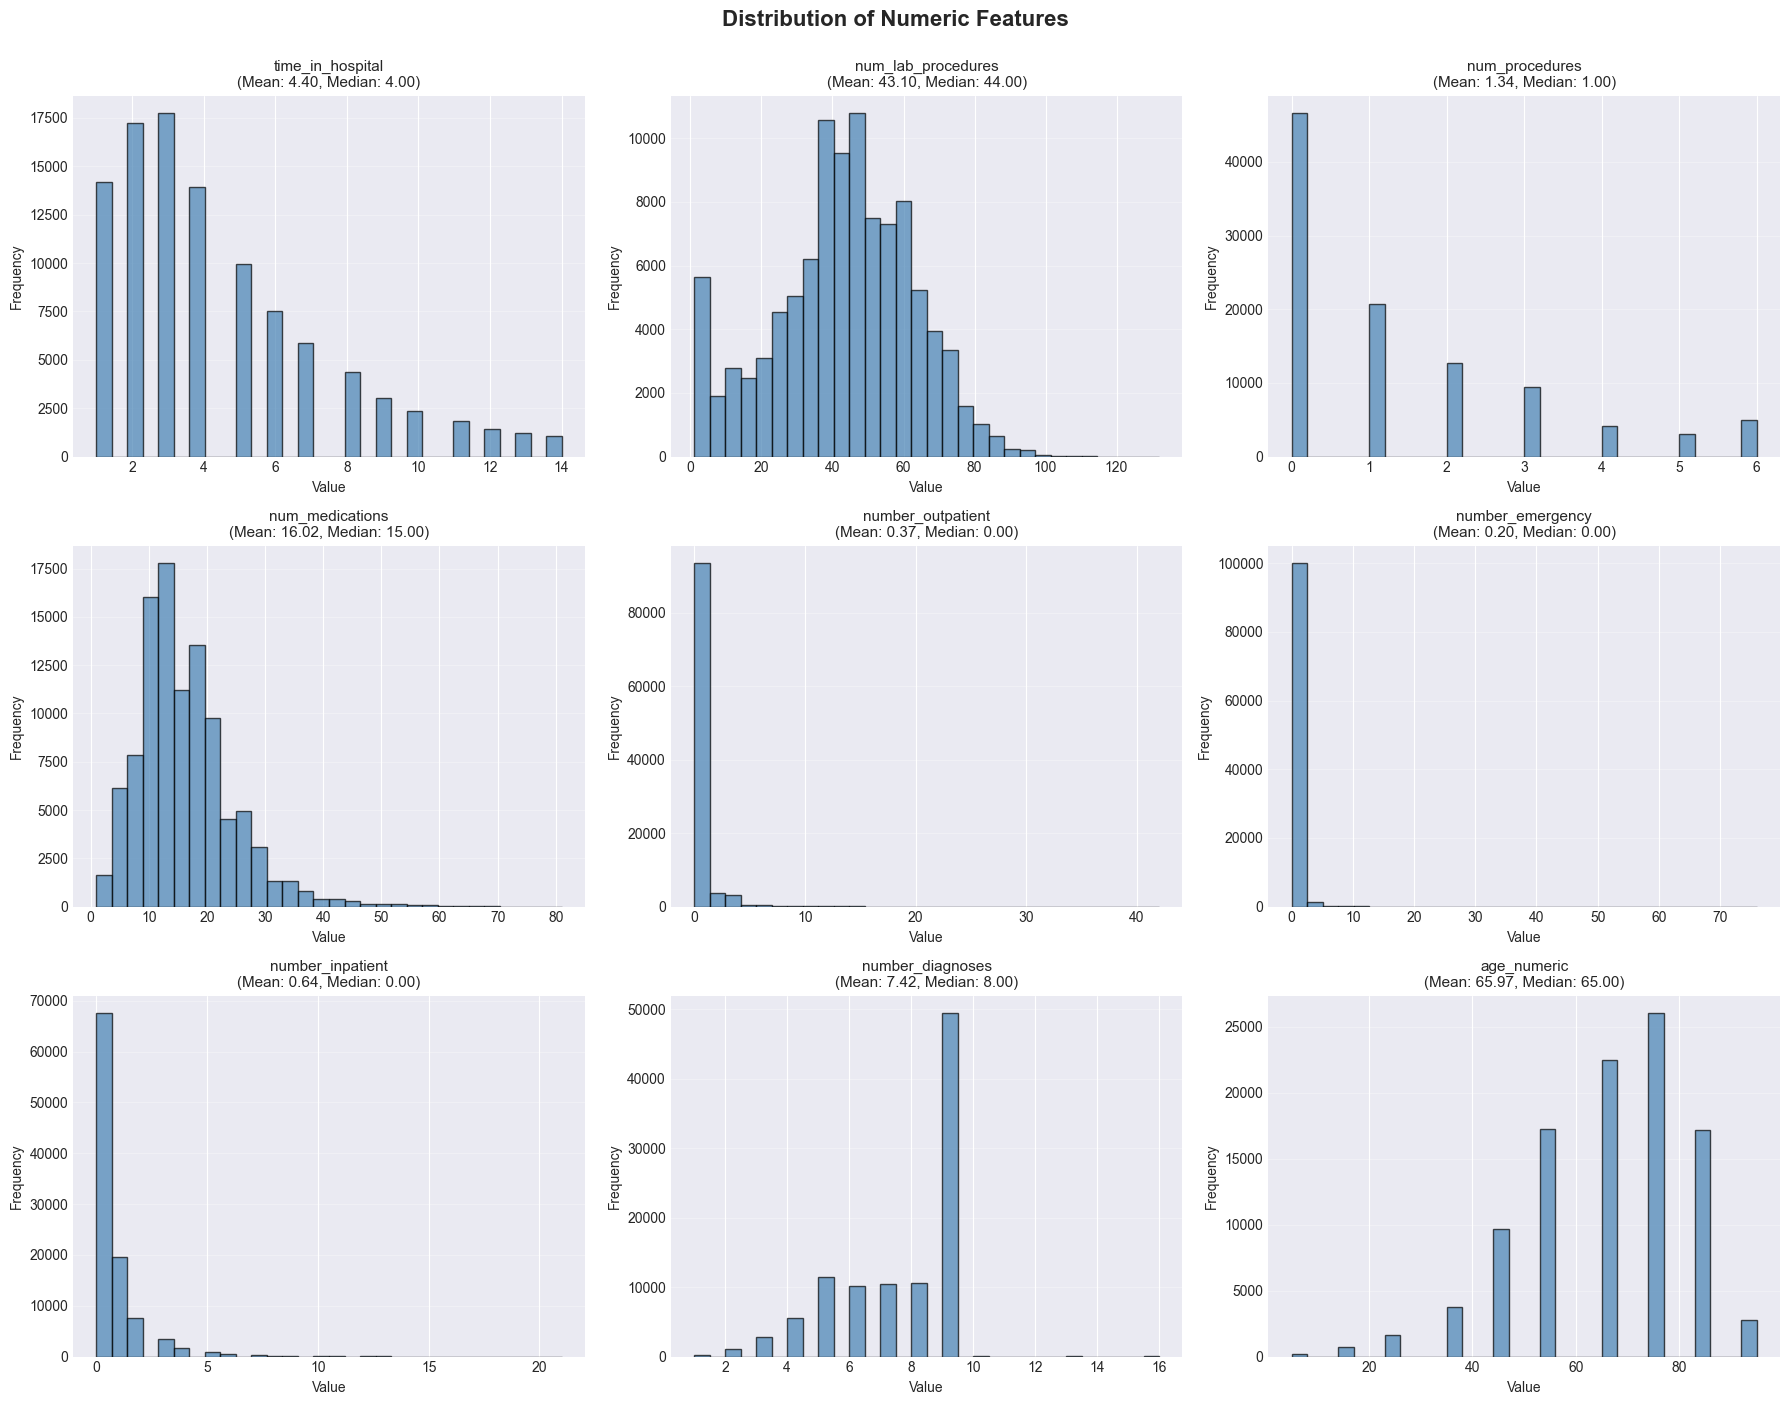


Statistical Summary of Numeric Features:
       time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count         101766.00           101766.00       101766.00        101766.00   
mean               4.40               43.10            1.34            16.02   
std                2.99               19.67            1.71             8.13   
min                1.00                1.00            0.00             1.00   
25%                2.00               31.00            0.00            10.00   
50%                4.00               44.00            1.00            15.00   
75%                6.00               57.00            2.00            20.00   
max               14.00              132.00            6.00            81.00   

       number_outpatient  number_emergency  number_inpatient  \
count          101766.00         101766.00         101766.00   
mean                0.37              0.20              0.64   
std                 1.27              0.93   

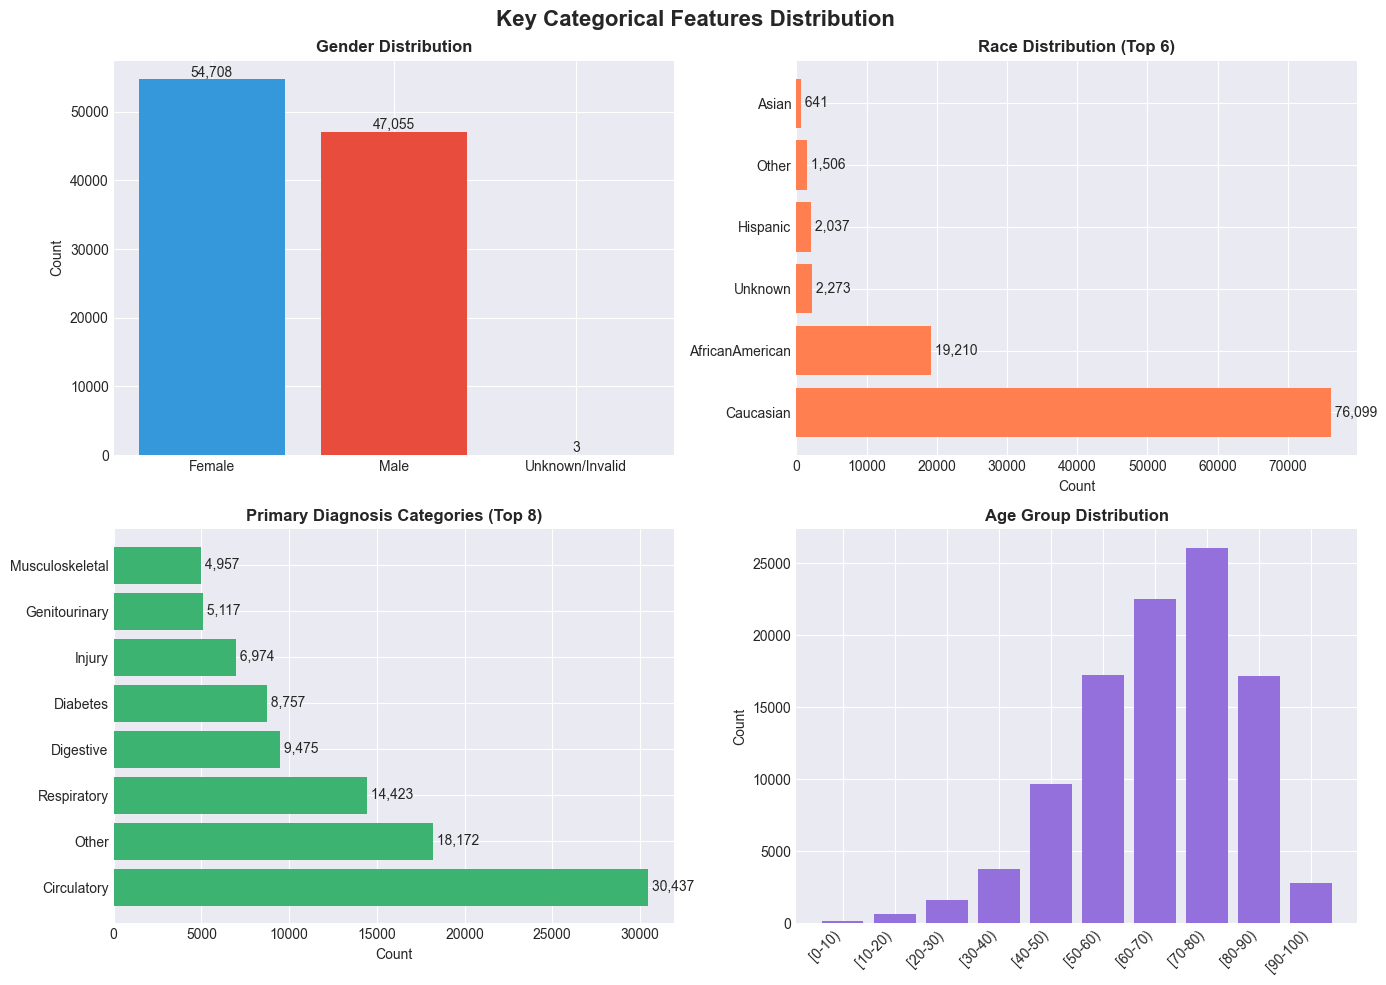

In [24]:
# ============================================================================
# SECTION 6: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

"""
EDA helps us understand:
1. Individual feature distributions
2. Relationships between features
3. Patterns related to readmission
4. Data-driven insights for healthcare stakeholders

We'll create comprehensive visualizations that tell a story.
"""

print("\n\n" + "=" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Create output directory for visualizations
import os
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')
    print("✓ Created 'visualizations' directory for output")

# 6.1 UNIVARIATE ANALYSIS - NUMERIC FEATURES
print("\n1. UNIVARIATE ANALYSIS - NUMERIC FEATURES")
print("-" * 80)

# Select key numeric features for analysis
numeric_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
                   'num_medications', 'number_outpatient', 'number_emergency',
                   'number_inpatient', 'number_diagnoses', 'age_numeric']

# Create distribution plots
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Distribution of Numeric Features', fontsize=16, fontweight='bold', y=1.00)

for idx, col in enumerate(numeric_features):
    if col in df.columns:
        row = idx // 3
        col_idx = idx % 3
        ax = axes[row, col_idx]
        
        # Histogram with KDE
        df[col].hist(bins=30, ax=ax, alpha=0.7, color='steelblue', edgecolor='black')
        ax.set_title(f'{col}\n(Mean: {df[col].mean():.2f}, Median: {df[col].median():.2f})',
                    fontsize=11)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/02_numeric_distributions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/02_numeric_distributions.png")
plt.show()

# Statistical summary
print("\nStatistical Summary of Numeric Features:")
print(df[numeric_features].describe().round(2))

# 6.2 UNIVARIATE ANALYSIS - CATEGORICAL FEATURES
print("\n\n2. UNIVARIATE ANALYSIS - CATEGORICAL FEATURES")
print("-" * 80)

# Gender distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Key Categorical Features Distribution', fontsize=16, fontweight='bold')

# Gender
if 'gender' in df.columns:
    gender_counts = df['gender'].value_counts()
    axes[0, 0].bar(gender_counts.index, gender_counts.values, color=['#3498db', '#e74c3c', '#95a5a6'])
    axes[0, 0].set_title('Gender Distribution', fontweight='bold')
    axes[0, 0].set_ylabel('Count')
    for i, v in enumerate(gender_counts.values):
        axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom')

# Race
if 'race' in df.columns:
    race_counts = df['race'].value_counts().head(6)
    axes[0, 1].barh(race_counts.index, race_counts.values, color='coral')
    axes[0, 1].set_title('Race Distribution (Top 6)', fontweight='bold')
    axes[0, 1].set_xlabel('Count')
    for i, v in enumerate(race_counts.values):
        axes[0, 1].text(v, i, f' {v:,}', va='center')

# Primary Diagnosis Category
if 'diag_1_category' in df.columns:
    diag_counts = df['diag_1_category'].value_counts().head(8)
    axes[1, 0].barh(diag_counts.index, diag_counts.values, color='mediumseagreen')
    axes[1, 0].set_title('Primary Diagnosis Categories (Top 8)', fontweight='bold')
    axes[1, 0].set_xlabel('Count')
    for i, v in enumerate(diag_counts.values):
        axes[1, 0].text(v, i, f' {v:,}', va='center')

# Age Distribution
if 'age' in df.columns:
    age_counts = df['age'].value_counts().sort_index()
    axes[1, 1].bar(range(len(age_counts)), age_counts.values, color='mediumpurple')
    axes[1, 1].set_title('Age Group Distribution', fontweight='bold')
    axes[1, 1].set_xticks(range(len(age_counts)))
    axes[1, 1].set_xticklabels(age_counts.index, rotation=45, ha='right')
    axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.savefig('visualizations/03_categorical_distributions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/03_categorical_distributions.png")
plt.show()




3. BIVARIATE ANALYSIS - RELATIONSHIP WITH READMISSION
--------------------------------------------------------------------------------

Analyzing numeric features by readmission status...
✓ Saved: visualizations/04_numeric_vs_readmission.png


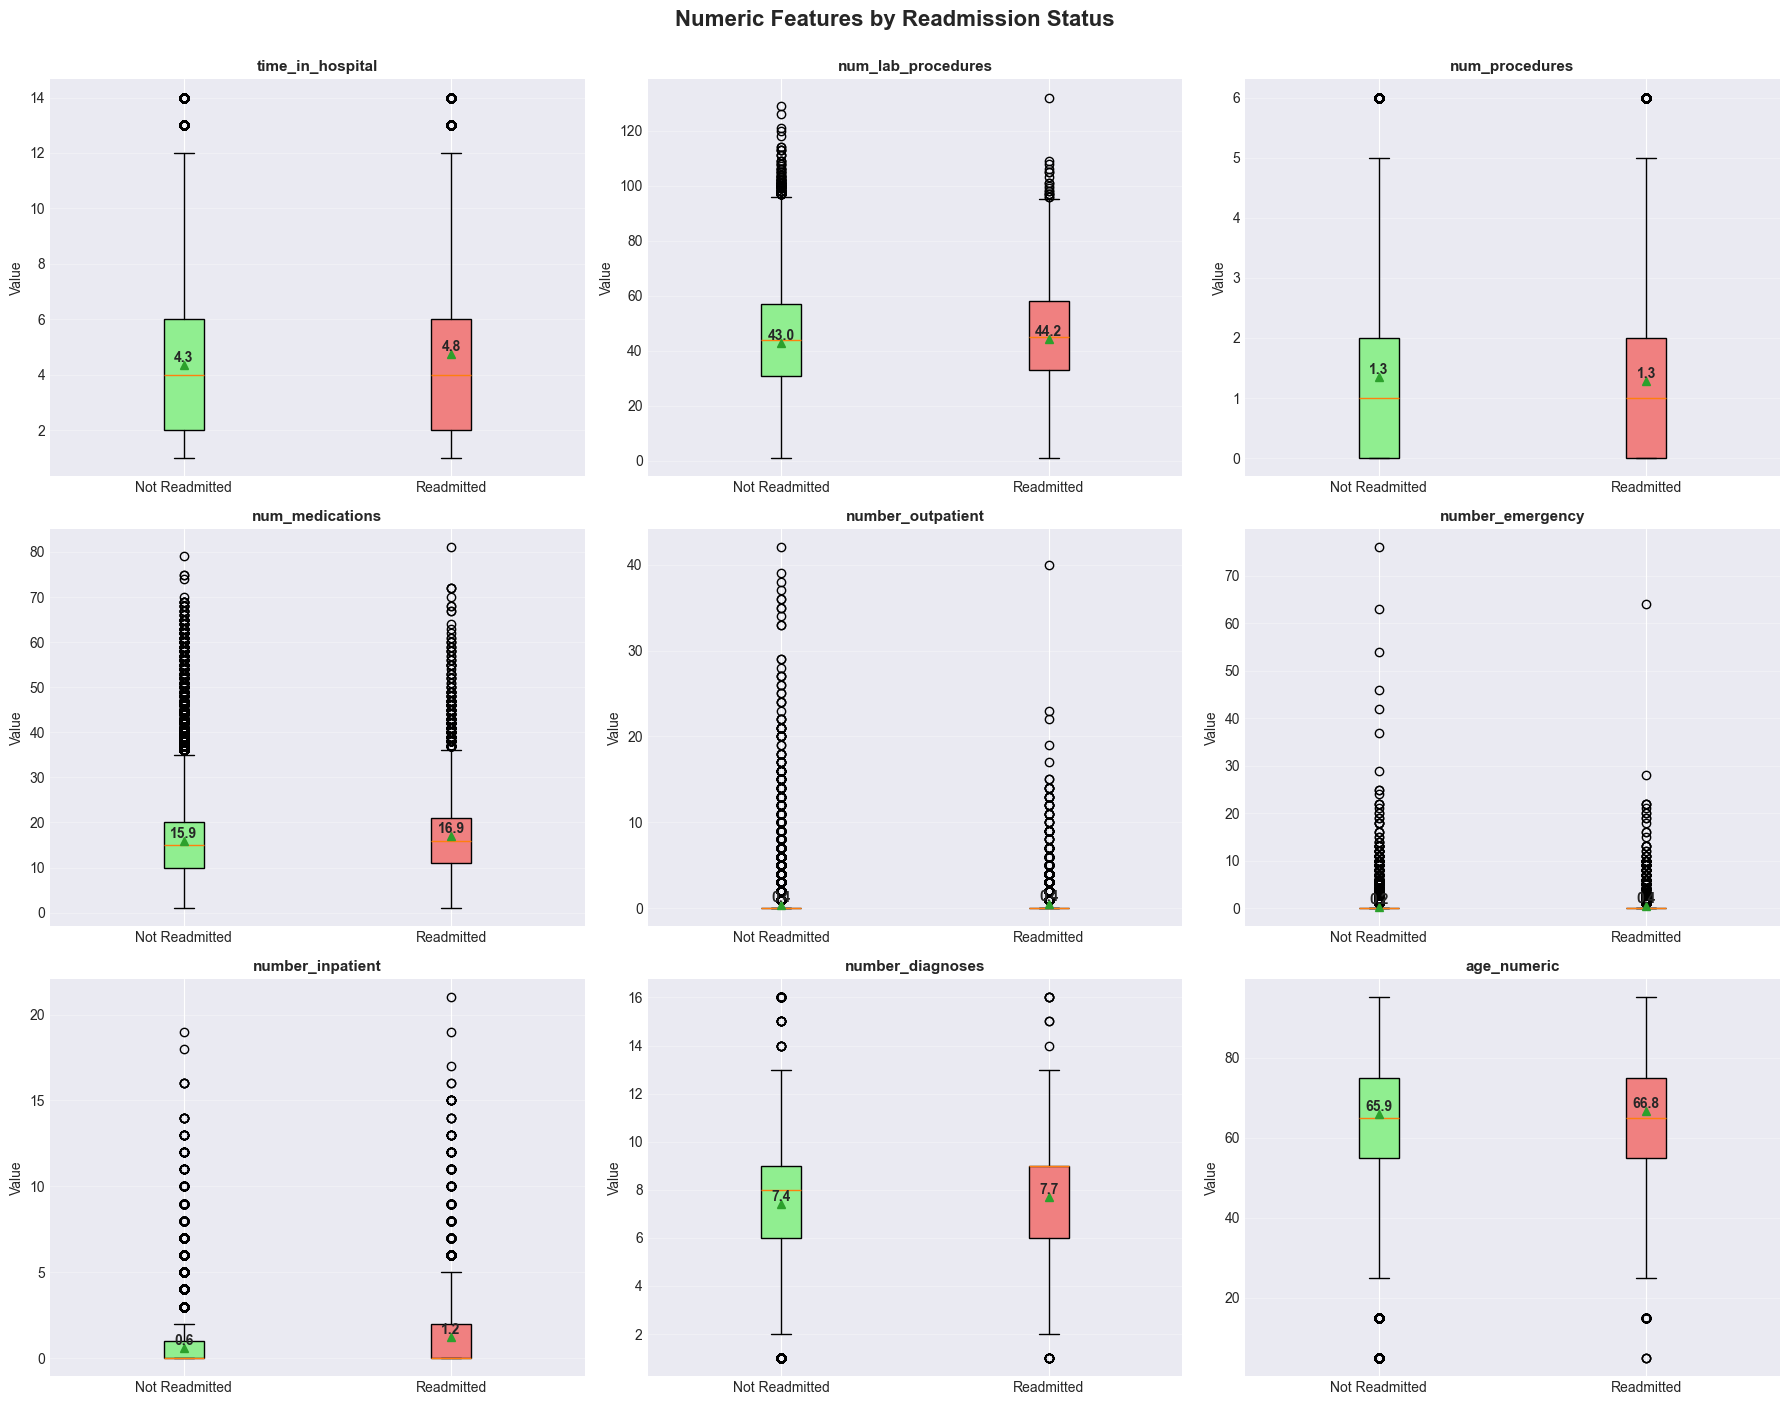


Mean Differences Between Readmitted and Not Readmitted Patients:
--------------------------------------------------------------------------------
time_in_hospital:
  Not Readmitted: 4.35
  Readmitted: 4.77
  Difference: +0.42 (+9.6%)

num_lab_procedures:
  Not Readmitted: 42.95
  Readmitted: 44.23
  Difference: +1.27 (+3.0%)

num_procedures:
  Not Readmitted: 1.35
  Readmitted: 1.28
  Difference: -0.07 (-4.9%)

num_medications:
  Not Readmitted: 15.91
  Readmitted: 16.90
  Difference: +0.99 (+6.2%)

number_outpatient:
  Not Readmitted: 0.36
  Readmitted: 0.44
  Difference: +0.08 (+21.1%)

number_emergency:
  Not Readmitted: 0.18
  Readmitted: 0.36
  Difference: +0.18 (+101.0%)

number_inpatient:
  Not Readmitted: 0.56
  Readmitted: 1.22
  Difference: +0.66 (+117.9%)

number_diagnoses:
  Not Readmitted: 7.39
  Readmitted: 7.69
  Difference: +0.30 (+4.1%)

age_numeric:
  Not Readmitted: 65.87
  Readmitted: 66.76
  Difference: +0.89 (+1.4%)



3.2 CATEGORICAL FEATURES VS READMISSION
----

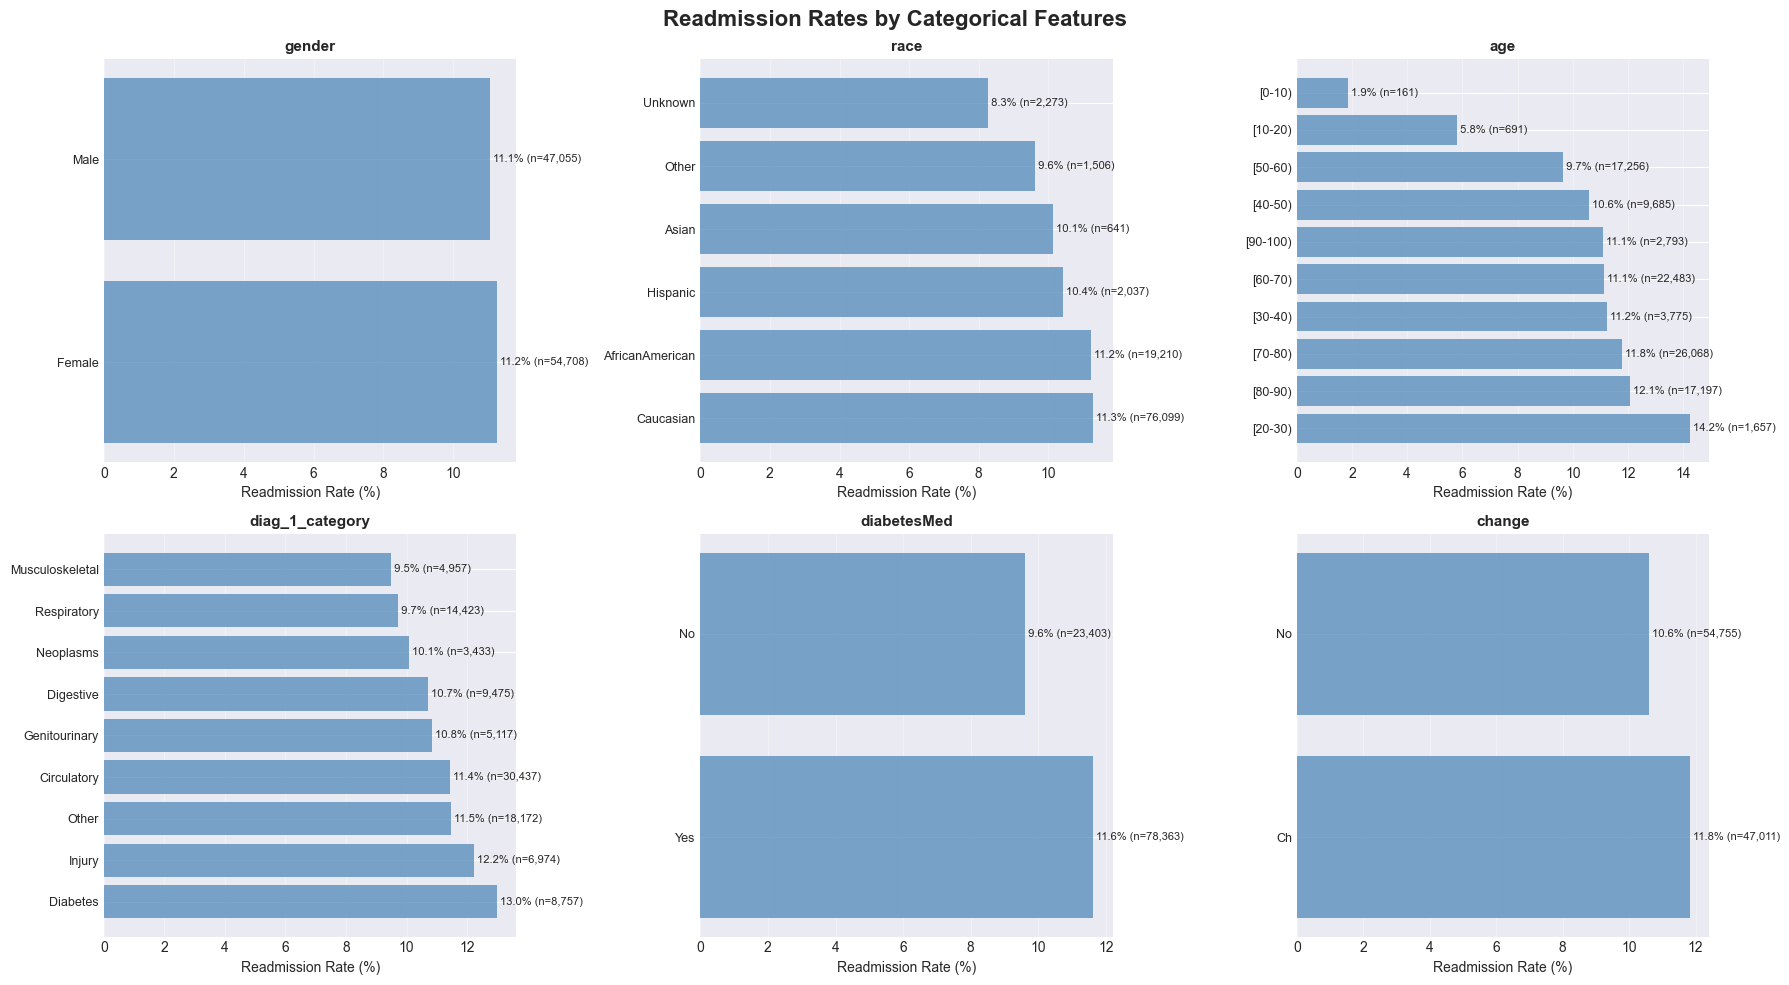



3.3 CORRELATION ANALYSIS
--------------------------------------------------------------------------------
✓ Saved: visualizations/06_correlation_matrix.png


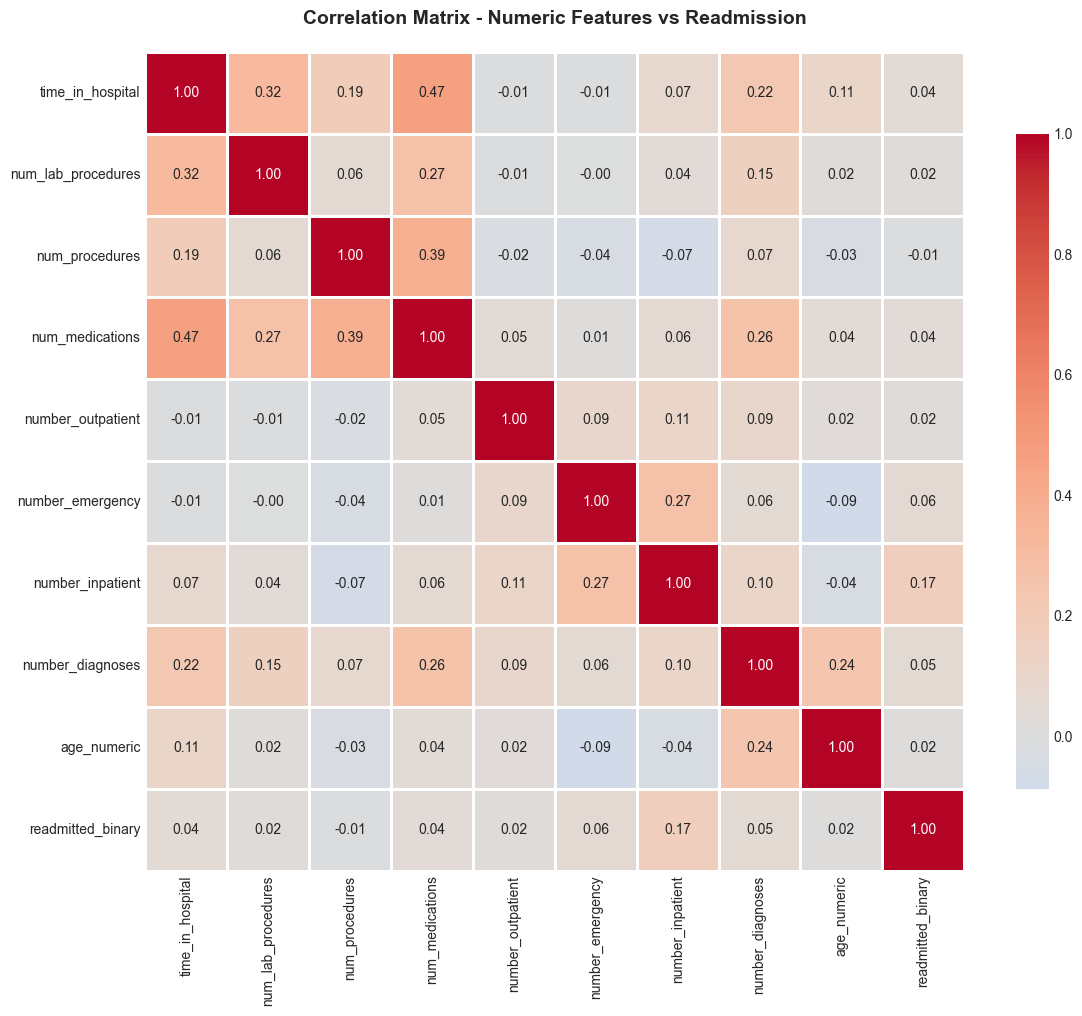


Top Correlations with Readmission:
--------------------------------------------------------------------------------
number_inpatient      0.165147
number_emergency      0.060747
number_diagnoses      0.049524
time_in_hospital      0.044199
num_medications       0.038432
num_lab_procedures    0.020364
number_outpatient     0.018893
age_numeric           0.017634
num_procedures       -0.012227


In [25]:
# 6.3 BIVARIATE ANALYSIS - FEATURES VS TARGET
print("\n\n3. BIVARIATE ANALYSIS - RELATIONSHIP WITH READMISSION")
print("-" * 80)

# 6.3.1 Numeric features vs Readmission
print("\nAnalyzing numeric features by readmission status...")

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Numeric Features by Readmission Status', fontsize=16, fontweight='bold', y=1.00)

for idx, col in enumerate(numeric_features):
    if col in df.columns:
        row = idx // 3
        col_idx = idx % 3
        ax = axes[row, col_idx]
        
        # Box plot comparing readmitted vs not readmitted
        data_to_plot = [
            df[df['readmitted_binary'] == 0][col].dropna(),
            df[df['readmitted_binary'] == 1][col].dropna()
        ]
        
        bp = ax.boxplot(data_to_plot, labels=['Not Readmitted', 'Readmitted'],
                       patch_artist=True, showmeans=True)
        
        # Color the boxes
        bp['boxes'][0].set_facecolor('lightgreen')
        bp['boxes'][1].set_facecolor('lightcoral')
        
        ax.set_title(f'{col}', fontsize=11, fontweight='bold')
        ax.set_ylabel('Value')
        ax.grid(axis='y', alpha=0.3)
        
        # Add mean values as text
        mean_0 = df[df['readmitted_binary'] == 0][col].mean()
        mean_1 = df[df['readmitted_binary'] == 1][col].mean()
        ax.text(1, mean_0, f'{mean_0:.1f}', ha='center', va='bottom', fontweight='bold')
        ax.text(2, mean_1, f'{mean_1:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/04_numeric_vs_readmission.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/04_numeric_vs_readmission.png")
plt.show()

# Calculate and display statistical differences
print("\nMean Differences Between Readmitted and Not Readmitted Patients:")
print("-" * 80)
for col in numeric_features:
    if col in df.columns:
        mean_not_readmit = df[df['readmitted_binary'] == 0][col].mean()
        mean_readmit = df[df['readmitted_binary'] == 1][col].mean()
        diff = mean_readmit - mean_not_readmit
        pct_diff = (diff / mean_not_readmit * 100) if mean_not_readmit != 0 else 0
        
        print(f"{col}:")
        print(f"  Not Readmitted: {mean_not_readmit:.2f}")
        print(f"  Readmitted: {mean_readmit:.2f}")
        print(f"  Difference: {diff:+.2f} ({pct_diff:+.1f}%)")
        print()

# 6.3.2 Categorical features vs Readmission
print("\n\n3.2 CATEGORICAL FEATURES VS READMISSION")
print("-" * 80)

# Readmission rate by key categorical features
categorical_features = ['gender', 'race', 'age', 'diag_1_category', 'diabetesMed', 'change']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Readmission Rates by Categorical Features', fontsize=16, fontweight='bold')

for idx, col in enumerate(categorical_features):
    if col in df.columns:
        row = idx // 3
        col_idx = idx % 3
        ax = axes[row, col_idx]
        
        # Calculate readmission rate by category
        readmit_rate = df.groupby(col)['readmitted_binary'].agg(['mean', 'count'])
        readmit_rate = readmit_rate[readmit_rate['count'] >= 100]  # Filter low-count categories
        readmit_rate = readmit_rate.sort_values('mean', ascending=False).head(10)
        
        # Create bar plot
        bars = ax.barh(range(len(readmit_rate)), readmit_rate['mean'] * 100, 
                       color='steelblue', alpha=0.7)
        ax.set_yticks(range(len(readmit_rate)))
        ax.set_yticklabels(readmit_rate.index, fontsize=9)
        ax.set_xlabel('Readmission Rate (%)', fontsize=10)
        ax.set_title(f'{col}', fontsize=11, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        # Add percentage labels
        for i, (rate, count) in enumerate(zip(readmit_rate['mean'], readmit_rate['count'])):
            ax.text(rate * 100, i, f' {rate*100:.1f}% (n={count:,})', 
                   va='center', fontsize=8)


plt.tight_layout()
plt.savefig('visualizations/05_categorical_vs_readmission.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/05_categorical_vs_readmission.png")
plt.show()

# 6.3.3 Correlation Analysis
print("\n\n3.3 CORRELATION ANALYSIS")
print("-" * 80)

# Select numeric columns for correlation
corr_columns = [col for col in numeric_features if col in df.columns]
corr_columns.append('readmitted_binary')

# Calculate correlation matrix
correlation_matrix = df[corr_columns].corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Numeric Features vs Readmission', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('visualizations/06_correlation_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visualizations/06_correlation_matrix.png")
plt.show()

# Print top correlations with target
print("\nTop Correlations with Readmission:")
print("-" * 80)
target_corr = correlation_matrix['readmitted_binary'].drop('readmitted_binary').sort_values(
    key=abs, ascending=False
)
print(target_corr.to_string())